In [2]:
# Import necessary libraries
import nd2
import matplotlib.pyplot as plt

In [3]:
# Load the ND2 file
file_path = "/nese/mit/group/boydenlab/Konstantinos/microscopy_data/01082025/01082025 swf702 ya sodium_aside_60slides_per_sec/worm_1nd2003.nd2"
#data = nd2.imread(file_path)

In [4]:
import dask.array as da

In [5]:
dask_array = nd2.imread(file_path, dask=True)

# Print basic information about the Dask array
print(f"Dask Array Shape: {dask_array.shape}")
print(f"Dask Array Data Type: {dask_array.dtype}")

# USE DASK BECAUSE OF I/O SPEED

with nd2.ND2File(file_path) as f:
    # Print general metadata
    print("Metadata:", f.metadata)
    
    # Print voxel sizes
    print("Voxel Size:", f.voxel_size())
    
    # Print the sizes of the dimensions (e.g., T, C, Y, X)
    print("Dimension Sizes:", f.sizes)
    
    # Access attributes like channel names
    channels = [ch.channel.name for ch in f.metadata.channels]
    print("Channels:", channels)
f.close()

Dask Array Shape: (20000, 2, 512, 1024)
Dask Array Data Type: uint16
Metadata: Metadata(contents=Contents(channelCount=2, frameCount=20000), channels=[Channel(channel=ChannelMeta(name='Mono', index=0, color=Color(r=255, g=255, b=255, a=1.0), emissionLambdaNm=None, excitationLambdaNm=None), loops=LoopIndices(NETimeLoop=None, TimeLoop=0, XYPosLoop=None, ZStackLoop=None), microscope=Microscope(objectiveMagnification=40.0, objectiveName='Apo LWD 40x WI λS DIC N2', objectiveNumericalAperture=1.15, zoomMagnification=1.0, immersionRefractiveIndex=1.333, projectiveMagnification=1.0, pinholeDiameterUm=50.0, modalityFlags=['fluorescence', 'spinningDiskConfocal']), volume=Volume(axesCalibrated=(True, True, False), axesCalibration=(0.325, 0.325, 1.0), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=16, cameraTransformationMatrix=(-0.999938509994522, 0.011089464817348451, -0.011089464817348451, -0.999938509994522), componentCount=1, 

/net/vast-storage.ib.cluster/scratch/vast/fiete/kirjner/miniforge3/envs/neuroconv/lib/python3.11/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)


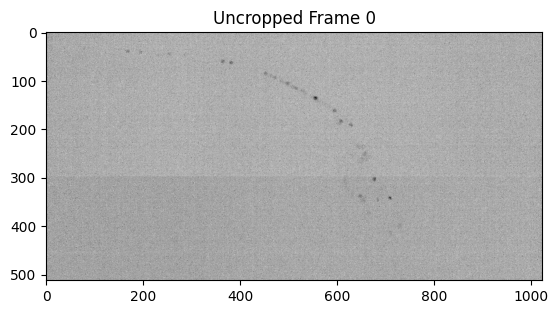

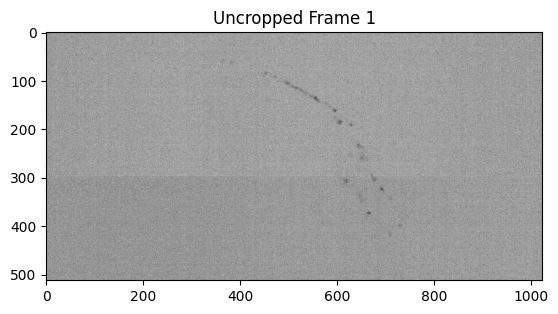

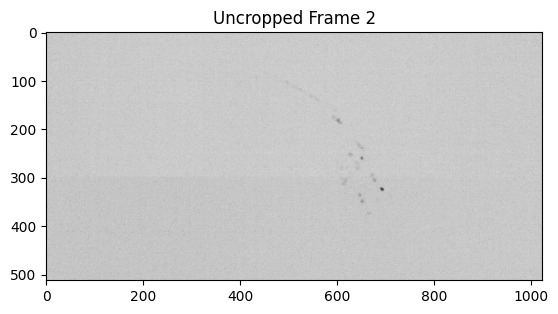

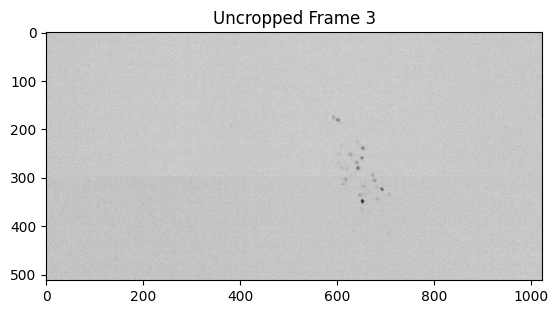

In [6]:
import matplotlib.pyplot as plt

# Compute a single frame for inspection (lazy -> eager)
for i in range(4):
    uncropped_frame = dask_array[i, 0].compute()

    # Visualize the uncropped frame
    plt.imshow(uncropped_frame, cmap='Greys')
    plt.title(f"Uncropped Frame {i}")
    plt.show()



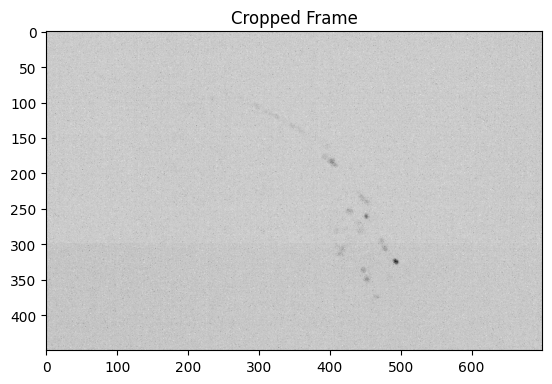

In [7]:
Y_MIN = 0
Y_MAX = 450
X_MIN = 200
X_MAX = 900

cropped_array = dask_array[:, :, Y_MIN:Y_MAX, X_MIN:X_MAX]

# Compute and visualize a cropped frame
cropped_frame = cropped_array[2, 0].compute()

plt.imshow(cropped_frame, cmap='Greys')
plt.title("Cropped Frame")
plt.show()

/net/vast-storage.ib.cluster/scratch/vast/fiete/kirjner/miniforge3/envs/neuroconv/lib/python3.11/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)


Time to load ND2 file lazily: 0.03 seconds
Subset Shape: (200, 2, 512, 1024)
Time to define lazy cropping: 0.00 seconds
Time to define lazy mean computation: 0.00 seconds
Time to define lazy std computation: 0.01 seconds
Time to compute mean intensities: 0.41 seconds
Time to compute std intensities: 0.87 seconds


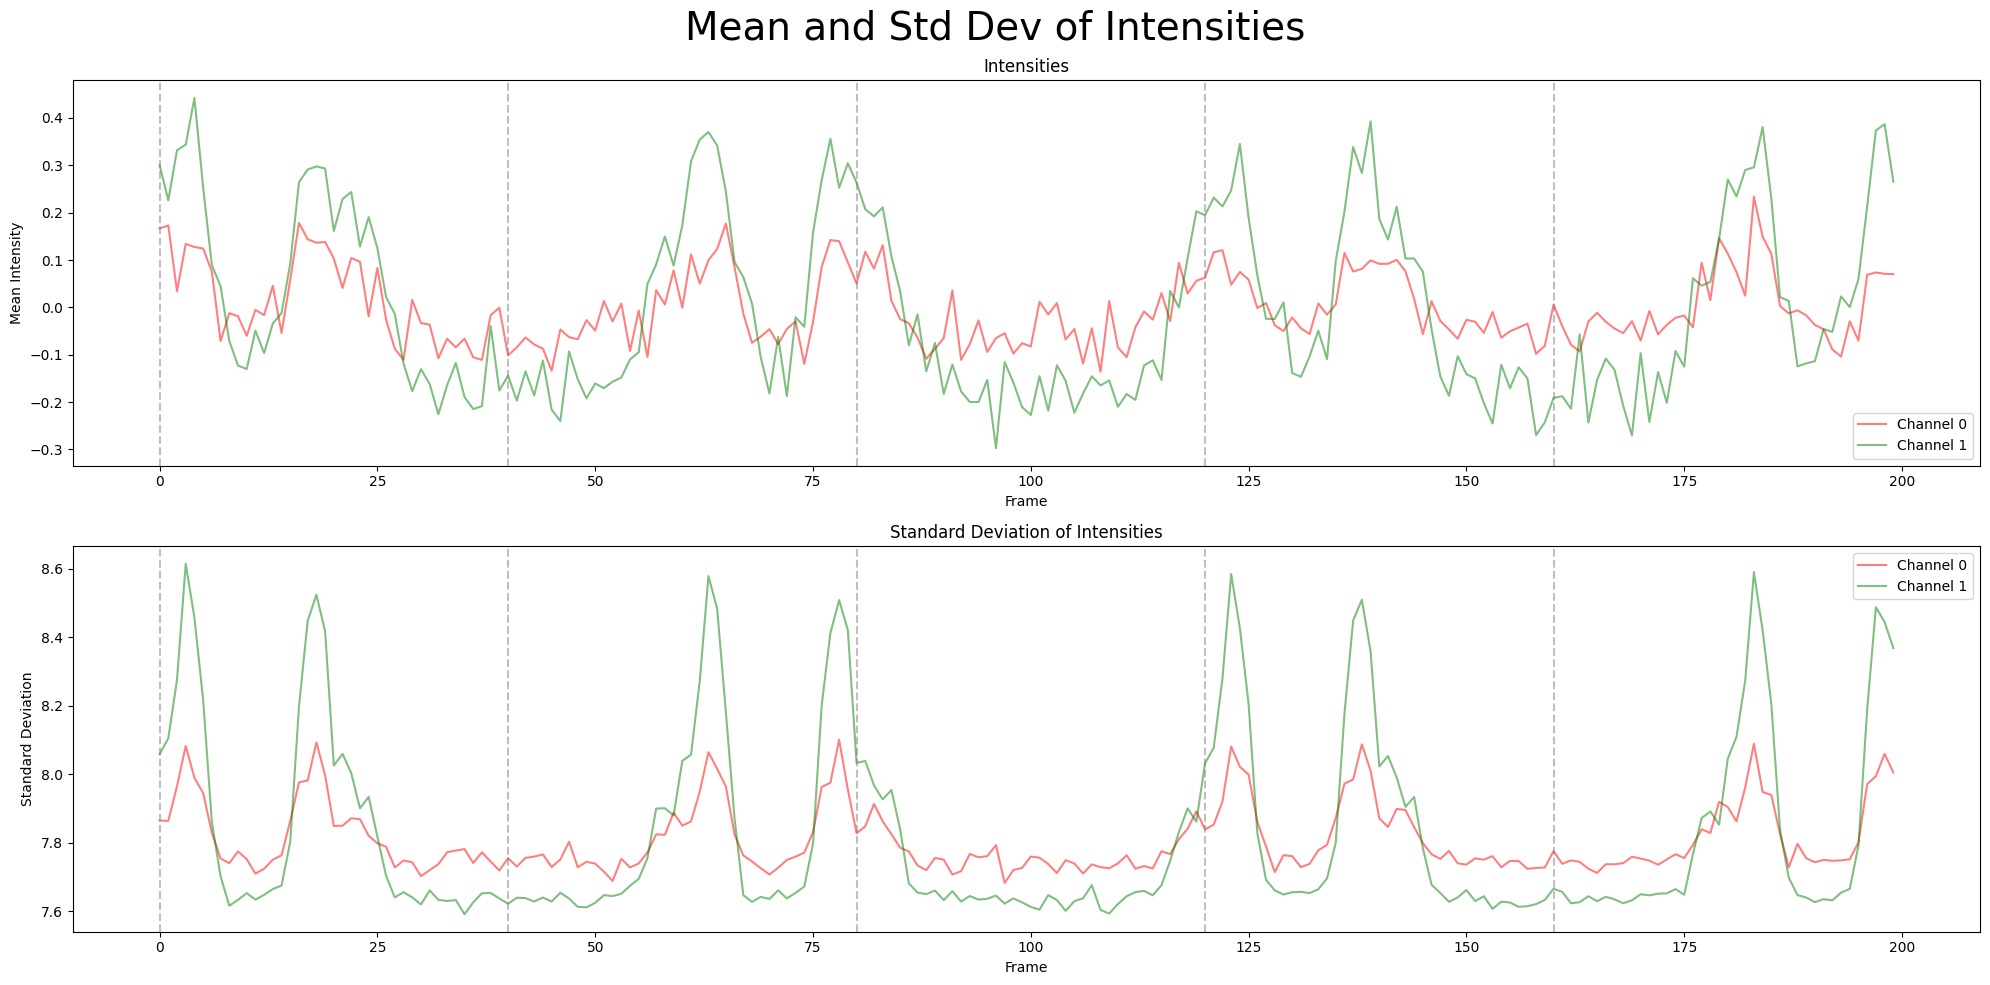

Time to generate plots: 0.58 seconds
Total time for the entire script: 1.90 seconds


In [8]:
import nd2
import matplotlib.pyplot as plt
import numpy as np
import time

# Start timing the overall script
overall_start = time.time()

# Load ND2 file as a Dask array
start = time.time()
dask_array = nd2.imread(file_path, dask=True)
end = time.time()
print(f"Time to load ND2 file lazily: {end - start:.2f} seconds")

# Limit to a subset of frames (e.g., first 200 frames)
FRAME_LIMIT = 200  # Adjust this as needed
subset_array = dask_array[:FRAME_LIMIT, :, :, :]  # Select first FRAME_LIMIT frames
print(f"Subset Shape: {subset_array.shape}")

# Define cropping boundaries
Y_MIN = 0
Y_MAX = 450
X_MIN = 200
X_MAX = 900

# Perform lazy cropping
start = time.time()
cropped_array = subset_array[:, :, Y_MIN:Y_MAX, X_MIN:X_MAX]
end = time.time()
print(f"Time to define lazy cropping: {end - start:.2f} seconds")

# Lazy mean and std computation
start = time.time()
mean_intensities = cropped_array.mean(axis=(2, 3))  # Across height and width
end = time.time()
print(f"Time to define lazy mean computation: {end - start:.2f} seconds")

start = time.time()
std_intensities = cropped_array.std(axis=(2, 3))
end = time.time()
print(f"Time to define lazy std computation: {end - start:.2f} seconds")

# Compute mean intensities
start = time.time()
mean_intensities_np = mean_intensities.compute()
end = time.time()
print(f"Time to compute mean intensities: {end - start:.2f} seconds")

# Compute std intensities
start = time.time()
std_intensities_np = std_intensities.compute()
end = time.time()
print(f"Time to compute std intensities: {end - start:.2f} seconds")

# Plotting function
def plot_intensity_vs_frame(mean_intensities, std_intensities, start_idx=0, frames_per_volume=40, title=None):
    start = time.time()

    fig, axs = plt.subplots(2, 1, figsize=(20, 10), tight_layout=True)

    # Plot mean intensities
    ax = axs[0]
    ax.set_title('Intensities')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Mean Intensity')

    xx = np.arange(-start_idx, mean_intensities.shape[0] - start_idx)
    ax.plot(xx, mean_intensities[:, 0] - np.mean(mean_intensities[:, 0]), label='Channel 0', color='red', alpha=0.5)
    ax.plot(xx, mean_intensities[:, 1] - np.mean(mean_intensities[:, 1]), label='Channel 1', color='green', alpha=0.5)
    ax.legend()

    # Plot standard deviations
    axx = axs[1]
    axx.set_title('Standard Deviation of Intensities')
    axx.set_xlabel('Frame')
    axx.set_ylabel('Standard Deviation')
    axx.plot(xx, std_intensities[:, 0], label='Channel 0', color='red', alpha=0.5)
    axx.plot(xx, std_intensities[:, 1], label='Channel 1', color='green', alpha=0.5)
    axx.legend()

    # Add vertical lines for volume boundaries
    for i in range(0, mean_intensities.shape[0] - start_idx, frames_per_volume):
        for ax in axs:
            ax.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

    if title:
        fig.suptitle(title, fontsize=28)
    plt.show()

    end = time.time()
    print(f"Time to generate plots: {end - start:.2f} seconds")

# Run the plotting function
plot_intensity_vs_frame(mean_intensities_np, std_intensities_np, start_idx=0, frames_per_volume=40, title="Mean and Std Dev of Intensities")

# Total script runtime
overall_end = time.time()
print(f"Total time for the entire script: {overall_end - overall_start:.2f} seconds")


In [ ]:
from tqdm import tqdm
import nd2

def track_nd2_file_loading(file_path):
    """
    Efficiently reads and processes frames in a large ND2 file.
    """
    try:
        # Open the ND2 file
        with nd2.ND2File(file_path) as nd2_file:
            # Total number of frames
            total_frames = nd2_file.metadata.contents.frameCount
            
            print(f"Loading ND2 file: {file_path}")
            print(f"Total frames: {total_frames}")
            
            # Iterate through frames with progress tracking
            for i, frame in enumerate(tqdm(nd2_file, desc="Processing frames", total=total_frames, unit="frame")):
                # Process each frame directly (e.g., just read the frame)
                process_frame(frame)

        print("ND2 file loading and processing complete.")

    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

def process_frame(frame):
    """
    Placeholder for processing each frame. Currently, it just calculates basic statistics.
    """
    # Calculate and print basic statistics
    mean_intensity = frame.mean()
    max_intensity = frame.max()
    min_intensity = framwith nd2.ND2File(file_path) as nd2_file:
    print(nd2_file.metadata)  # View all metadata availablee.min()

    # Print frame stats (or log them as needed)
    print(f"Frame stats - Mean: {mean_intensity:.2f}, Max: {max_intensity}, Min: {min_intensity}")

# Define the file path
file_path = "/nese/mit/group/boydenlab/Konstantinos/microscopy_data/01082025/01082025 swf702 ya sodium_aside_60slides_per_sec/worm_1nd2003.nd2"

# Call the function to process the file
track_nd2_file_loading(file_path)


In [1]:
import h5py

# Open the HDF5 file
file_path = '/om2/user/kirjner/WormWork/targettrack/unlabeled_worm_head_example.h5'
with h5py.F# Load the ND2 file
file_path = "/nese/mit/group/boydenlab/Konstantinos/microscopy_data/01082025/01082025 swf702 ya sodium_aside_60slides_per_sec/worm_1nd2003.nd2"
data = nd2.imread(file_path)ile(file_path, 'r') as f:
    # Check if the 'pointdat' dataset exists
    if 'pointdat' in f:
        # Access the 'pointdat' dataset
        pointdat = f['pointdat']
        
        # Print basic information about 'pointdat'
        print("Dataset: 'pointdat'")
        print(f"Shape: {pointdat.shape}")
        print(f"Dtype: {pointdat.dtype}")
        
        # Optionally, preview a subset of data
        print("\nPreview of data (first 5 entries):")
        print(pointdat[:5])
    else:
        print("'pointdat' dataset not found in the file.")

    # List all attributes in the file (optional)
    print("\nFile attributes:")
    for key in f.attrs.keys():
        print(f"{key}: {f.attrs[key]}")

    # List all datasets/groups at the root level
    print("\nMain groups/datasets:")
    for key in f.keys():
        print(key)


Dataset: 'pointdat'
Shape: (3002, 85, 3)
Dtype: float32

Preview of data (first 5 entries):
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]]

File attributes:
C: 2
D: 16
H: 160
N_neurons: 84
N_points: 84
T: 3002
W: 256
dset_path_from_GUI: /nese/mit/group/boydenlab/Konstantinos/targettrack_data/unlabeled_worm_head_example.h5
name: 184
pixel_scale: [1 1 4]
pointdat: True

Main groups/datasets:
0
1
10
100
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
101
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
102
1020
1021
1022


In [4]:
import h5py

# Open the file
f = h5py.File('/om2/user/kirjner/WormWork/targettrack/unlabeled_worm_head_example.h5', 'r')

# Inspect the structure of datasets
for key in f.keys():
    print(f"Dataset: {key}")
    data = f[key]
    print(f" - Shape: {data.shape}")
    print(f" - Dtype: {data.dtype}")
    print(f" - Attributes: {list(data.attrs.keys())}")

f.close()


Dataset: 0


KeyError: "Unable to open object (object '0' doesn't exist)"